In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import os
from sklearn.model_selection import train_test_split

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def show_image(path):
    im = read_image(path)
    plt.imshow(im)

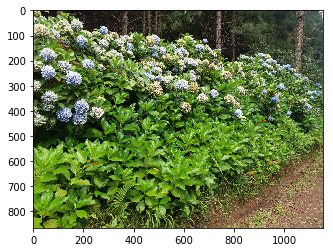

In [4]:
sample_pic = './data/train/100.jpg'
show_image(sample_pic)

### Read Data

In [5]:
def get_filenames(path, folder):
    """ function to retrive all image names in train/test folder
    """
    file_path = os.path.join(path, folder) 
    file_names = [f for f in os.listdir(file_path) if not f.startswith(".")]
    
    return file_names

def get_labels(file_names, label_file):
    """ function to find image labels given list of image names
    """
    label_df = pd.read_csv(label_file)
    label_names = [int(f.replace(".jpg",'')) for f in file_names]
    labels = [label_df.iloc[n-1]['invasive'] for n in label_df.name.values] 
    
    return labels

In [6]:
files = get_filenames('./data', 'train')
labels = get_labels(files, './data/train_labels.csv')

In [7]:
train_files, valid_files, train_labels, valid_labels = train_test_split(files, labels, test_size=0.15, random_state=1)

In [8]:
print("%d in train, %d in validaiton" %(len(train_files), len(valid_files)))

1950 in train, 345 in validaiton


### Data Augmentation

In [10]:
import math

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

### Dataset

In [99]:
class Species_Dataset(Dataset):
    def __init__(self, files, labels=None, folder='train', transform=False, size=300):
        self.files = files
        self.labels = labels
        self.folder = folder
        self.size = size
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = os.path.join('./data', self.folder, self.files[idx])
        x = cv2.imread(path).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        
        if self.transform:
            size2 = int(self.size * 1.05)
            x = cv2.resize(x, (size2, size2))
            x = random_crop(x, self.size, self.size)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.size, self.size))
        
        # substract numbers from resnet34
        x = normalize(x)
        
        if self.labels:
            return np.rollaxis(x, 2), self.labels[idx]
        else: 
            return np.rollaxis(x, 2)

In [100]:
train_ds = Species_Dataset(train_files, train_labels, transform=True)
valid_ds = Species_Dataset(valid_files, valid_labels)

In [101]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Model

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

## Learning rate finder

In [58]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [61]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = "mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [62]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=1e-4)

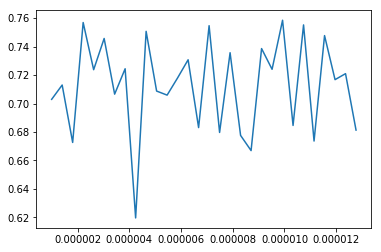

In [63]:
plt.plot(lrs[:30], losses[:30])
plt.show()

### Triangular learning rate training

In [64]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [65]:
def train_triangular_policy(model, train_dl, valid_dl, epochs=4, lr_low=1e-5, lr_high=0.01):
    idx = 0
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [66]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().unsqueeze(1)
        out = model(x)
        pred = (out > 0.0).long()
        correct += pred.eq(y.data).sum().item()
        y = y.float()
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

### Training with triangular rates

In [71]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, epochs=4, steps=3, lr_low=1e-6, lr_high=1e-4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, epochs, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [69]:
model = Net().cuda()

In [70]:
val_metrics(model, valid_dl)

val loss and accuracy 0.7110996014829994 0.35942028985507246


In [72]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 0.7032437438231248
val loss and accuracy 0.6953376909960871 0.5420289855072464
train loss 0.6963082175377088
val loss and accuracy 0.6835598427316417 0.5710144927536231
train loss 0.6798133834203084
val loss and accuracy 0.681360441705455 0.5855072463768116
train loss 0.6772726963727902
val loss and accuracy 0.6861617991889732 0.5739130434782609
----End of step Time elapsed 0:09:35.373777


### Predict

In [108]:
test_files = files = get_filenames('./data', 'test')
test_ds = Species_Dataset(test_files, folder='test',transform=False)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [127]:
def predict(model, test_dl):
    model.eval()
    preds = []
    ys = []
    for x in test_dl:
        x = x.cuda().float()
        out = model(x)
        preds.append(out.cpu().detach().numpy())

    return np.vstack(preds)

In [128]:
preds = predict(model, test_dl)

In [131]:
def sigmoid(x): return 1/(1+np.exp(-x))

In [132]:
prob_preds = sigmoid(preds.reshape(-1))

In [133]:
prob_preds

array([0.3808635 , 0.4340813 , 0.48083672, ..., 0.569912  , 0.39760515,
       0.6945256 ], dtype=float32)

In [141]:
def pred_to_df(files, preds):
    name = [int(f.replace(".jpg",'')) for f in files]
    pred = pd.DataFrame({"name": name, "invasive":preds})
    pred = pred.sort_values(by='name')
    pred = pred[['name', 'invasive']]
    return pred

In [142]:
pred_df = pred_to_df(test_files, prob_preds)

In [144]:
pred_df.to_csv('submission.csv', index=False)

In [145]:
pred_df.head()

,name,invasive
25,1,0.538619
767,2,0.568192
396,3,0.439845
1159,4,0.503231
214,5,0.626145
